[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ijdoc/wandb-demos/blob/main/pytorch/10-demo.ipynb)

# PyTorch Model Training

## Setup

### Import Libraries

In [1]:
!ltt install torch
!pip install timm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm # Where the model is stored

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.9.18 (main, Nov  2 2023, 22:22:37) 
[GCC 11.4.0]
PyTorch version 2.1.0+cu118
Torchvision version 0.16.0+cu118
Numpy version 1.26.1
Pandas version 2.1.2


### Prepare Data 

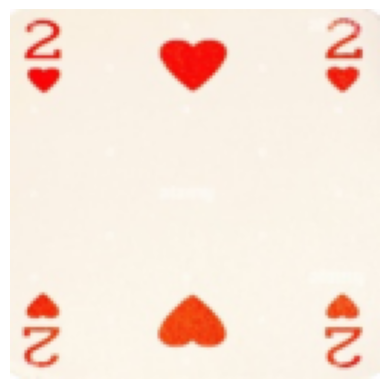

In [2]:
import random

class PlayingCardsDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
      return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

def get_dataloaders(img_size, batch_size):
  convert = transforms.Compose([
      transforms.Resize((img_size, img_size)),
      transforms.ToTensor(),
  ])
  # Load datasets as tensors
  train_folder = './artifacts/playing-cards:v0/train/'
  valid_folder = './artifacts/playing-cards:v0/valid/'
  test_folder = './artifacts/playing-cards:v0/test/'

  train_dataset = PlayingCardsDataset(train_folder, transform=convert)
  val_dataset = PlayingCardsDataset(valid_folder, transform=convert)
  test_dataset = PlayingCardsDataset(test_folder, transform=convert)

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  return {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

def show_sample(img_size):
  resize = transforms.Compose([
      transforms.Resize((img_size, img_size)),
  ])
  dataset = PlayingCardsDataset("./artifacts/playing-cards:v0/train", transform=resize)
  image, label = random.choice(dataset)
  plt.imshow(image)
  plt.axis('off')  # Hide the axis
  plt.show()


show_sample(128)

### Prepare Model

In [3]:
class CardClassifier(nn.Module):
  def __init__(self, num_classes=53):
    super(CardClassifier, self).__init__()

    # Define base model
    self.base_model = timm.create_model('efficientnet_b0', pretrained=True)

    # Remove last layer
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])
    # Keep a reference to the removed layer so we know how many connections
    # we need for the new last layer
    removed_layer = list(self.base_model.children())[-1]

    # Recreate the last layer (the classifier)
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(removed_layer.in_features, num_classes)
    )

  def forward(self, x):
    # Connect these parts and return the output
    x = self.features(x)
    return self.classifier(x)

# model = CardClassifier(num_classes)
# predictions = model(images)
# predictions.shape  # [batch_size, num_classes]

### Helper Functions

In [4]:
import os

def init_training(config):
  # Device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f'Training on {device}')

  # Dataloaders
  dataloaders = get_dataloaders(config["img_size"], config["batch_size"])

  # Model
  model = CardClassifier()
  model = model.to(device)
  # Loss function
  loss_fn = nn.CrossEntropyLoss()

  # Optimizer
  optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
  return device, dataloaders, model, loss_fn, optimizer

def train_step(model, dataloader, loss_fn, optimizer, device):
  model.train()  # Set the model to training mode
  total_loss = 0

  for X_batch, y_batch in dataloader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to the appropriate device (CPU/GPU)

    optimizer.zero_grad()  # Reset gradients to zero to avoid accumulation

    y_pred = model(X_batch)  # Forward pass: compute the model output
    loss = loss_fn(y_pred, y_batch)  # Compute the loss
    total_loss += loss.item()

    loss.backward()  # Backward pass: compute the gradient of the loss with respect to model parameters
    optimizer.step()  # Update parameters

  average_loss = total_loss / len(dataloader)
  return average_loss  # Return the average loss for the epoch

def validate_step(model, dataloader, loss_fn, device):
  model.eval()  # Set the model to evaluation mode
  total_loss = 0
  total_correct = 0

  with torch.no_grad():  # No gradients needed for validation, saves memory and computations
    for X_batch, y_batch in dataloader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      y_pred = model(X_batch)
      loss = loss_fn(y_pred, y_batch)
      total_loss += loss.item()

      # Assuming y_pred are raw logits, you could adapt this depending on your output
      predicted = torch.argmax(y_pred, dim=1)
      total_correct += (predicted == y_batch).sum().item()

  average_loss = total_loss / len(dataloader)
  accuracy = total_correct / len(dataloader.dataset)

  return average_loss, accuracy  # Return the average loss and accuracy for the validation set

def save_model_checkpoint(model, optimizer, epoch, loss):
  # Save the model state and the optimizer state
  checkpoint = {
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
      # You can add more items to the checkpoint if needed
  }

  # Specify the directory you want to create
  checkpoints_dir = "./checkpoints"

  # Check whether the specified path exists or not
  if not os.path.exists(checkpoints_dir):
      os.makedirs(checkpoints_dir)  # Create a new directory because it does not exist
  filepath = f'{checkpoints_dir}/{epoch}_card_classifier_checkpoint.pth'

  # Save to file
  torch.save(checkpoint, filepath)

  return filepath

## Training

1. Install the W&B Python SDK:
   
 ```shell
 pip install wandb
 ```

2. Integrate the W&B Python SDK:

In [5]:
# 1. Import the W&B Python SDK
import wandb

config = {
  "epochs": 5,
  "learning_rate": 0.0001,
  "img_size": 128,
  "batch_size": 32,
}

# 2. Initialize logging
wandb.init(config=config, job_type="train")

device, dataloaders, model, loss_fn, optimizer = init_training(config)

for epoch in range(config["epochs"]):
  loss = train_step(model, dataloaders["train"], loss_fn, optimizer, device)
  val_loss, accuracy = validate_step(model, dataloaders["val"], loss_fn, device)

  print(f'Epoch {epoch+1}/{config["epochs"]}, '
        f'Training Loss: {loss:.4f}, '
        f'Validation Loss: {val_loss:.4f}, '
        f'Accuracy: {accuracy:.4f}')
  # 3. Log metrics
  wandb.log({"train/loss": loss, "val/loss": val_loss, "val/acc": accuracy})

# 4. Done!!
wandb.finish()

wandb: Currently logged in as: iamjdoc (team-jdoc). Use `wandb login --relogin` to force relogin


Training on cuda:0


/home/jdoc/.local/share/virtualenvs/wandb-demos-Mz9mR-61/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/5, Training Loss: 3.0816, Validation Loss: 1.8491, Accuracy: 0.5509
Epoch 2/5, Training Loss: 1.5973, Validation Loss: 0.8410, Accuracy: 0.7962
Epoch 3/5, Training Loss: 0.9299, Validation Loss: 0.4864, Accuracy: 0.8604
Epoch 4/5, Training Loss: 0.5721, Validation Loss: 0.3408, Accuracy: 0.9019
Epoch 5/5, Training Loss: 0.3492, Validation Loss: 0.3053, Accuracy: 0.9094


train/loss,█▄▂▂▁
val/acc,▁▆▇██
val/loss,█▃▂▁▁
train/loss,0.34922
val/acc,0.90943
val/loss,0.30525


### With Artifacts

In [7]:
import wandb

config = {
  "epochs": 5,
  "learning_rate": 0.0001,
  "img_size": 128,
  "batch_size": 32,
}

wandb.init(config=config, job_type="train")

# 1. Reference the dataset used
wandb.use_artifact('team-jdoc/datasets/playing-cards:v0', type='dataset')

device, dataloaders, model, loss_fn, optimizer = init_training(config)

for epoch in range(config["epochs"]):
  loss = train_step(model, dataloaders["train"], loss_fn, optimizer, device)
  val_loss, accuracy = validate_step(model, dataloaders["val"], loss_fn, device)

  print(f'Epoch {epoch+1}/{config["epochs"]}, '
        f'Training Loss: {loss:.4f}, '
        f'Validation Loss: {val_loss:.4f}, '
        f'Accuracy: {accuracy:.4f}')
  wandb.log({"train/loss": loss, "val/loss": val_loss, "val/acc": accuracy})

# 2. Log the resulting model
model_path = save_model_checkpoint(model, optimizer, epoch, loss)
wandb.log_artifact(model_path, type='model')

wandb.finish()

Training on cuda:0
Epoch 1/5, Training Loss: 3.1060, Validation Loss: 1.8291, Accuracy: 0.5321
Epoch 2/5, Training Loss: 1.6264, Validation Loss: 0.8554, Accuracy: 0.7887
Epoch 3/5, Training Loss: 0.9494, Validation Loss: 0.4762, Accuracy: 0.8528
Epoch 4/5, Training Loss: 0.5679, Validation Loss: 0.3171, Accuracy: 0.9208
Epoch 5/5, Training Loss: 0.3557, Validation Loss: 0.2817, Accuracy: 0.9358


train/loss,█▄▃▂▁
val/acc,▁▅▇██
val/loss,█▄▂▁▁
train/loss,0.35566
val/acc,0.93585
val/loss,0.28174


## Testing

In [ ]:
# TODO: Calculate accuracy on test set

## Debug

In [ ]:
wandb.finish()